In [2]:
%load_ext autoreload
%autoreload 2

In [111]:
import time

import numpy as np
from gym.envs.classic_control import rendering
import tensorflow as tf

from data import env_sequences_generator
from model import EnvModel
from utils import plot_pairwise_frames

tf.enable_eager_execution()

In [116]:
def make_dataset(bs, seq_len):
    return tf.data.Dataset.from_generator(
        generator=lambda: env_sequences_generator(seq_len),
        output_types=((tf.float32,), (tf.float32, tf.float32, tf.bool)),
    ).batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [117]:
model = EnvModel(memory_size=32, output_shape=(210, 160))
model.net.summary()

33600
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
input_sequence (Dense)          (None, None, 32)     128         user_input[0][0]                 
__________________________________________________________________________________________________
next_state (LSTM)               (None, None, 32)     8320        input_sequence[0][0]             
__________________________________________________________________________________________________
vision_projection (Dense)       (None, None, 33600)  1108800     next_state[0][0]                 
_____________________________________________________________________________________

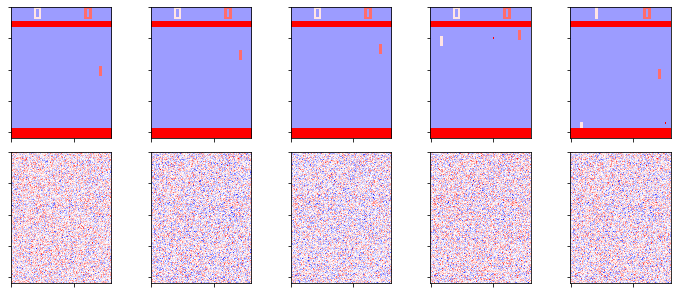

Epoch 1/250
100/100 [==============================] - 433s 4s/step - loss: 0.0924 - vision_reshape_loss: 0.0330 - reward_loss: 8.2212e-04 - done_loss: 0.0586 - vision_reshape_mean_squared_error: 0.0330 - vision_reshape_acc: 0.0263 - reward_mean_squared_error: 8.2212e-04 - reward_acc: 1.0000 - done_mean_squared_error: 0.0586 - done_acc: 0.9565 - val_loss: 0.0113 - val_vision_reshape_loss: 0.0050 - val_reward_loss: 1.7092e-05 - val_done_loss: 0.0064 - val_vision_reshape_mean_squared_error: 0.0050 - val_vision_reshape_acc: 0.0334 - val_reward_mean_squared_error: 1.7092e-05 - val_reward_acc: 1.0000 - val_done_mean_squared_error: 0.0064 - val_done_acc: 1.0000


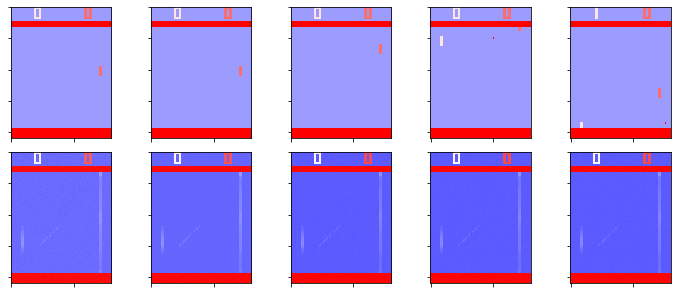

Epoch 2/250
 39/100 [==========>...................] - ETA: 4:04 - loss: 0.0098 - vision_reshape_loss: 0.0042 - reward_loss: 1.3545e-05 - done_loss: 0.0056 - vision_reshape_mean_squared_error: 0.0042 - vision_reshape_acc: 0.0304 - reward_mean_squared_error: 1.3545e-05 - reward_acc: 1.0000 - done_mean_squared_error: 0.0056 - done_acc: 1.0000

In [ ]:
dataset = make_dataset(bs=16, seq_len=32)


class PlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        plot_pairwise_frames(
            dataset=make_dataset(1, 128),
            predictor=lambda x: model.net.predict(x),
            which_frames=[1, 4, 16, 64, 127]
        )
        plt.show()


model.net.fit_generator(
    generator=dataset,
    validation_data=dataset,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=250,
    callbacks=[PlotCallback()]
)